In [1]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import seaborn as sb
import pickle
import os
import glob
from tqdm import tqdm_notebook
from netCDF4 import Dataset

In [35]:
pd.set_option('display.float_format', '{:.4e}'.format)

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

% matplotlib inline

$$\begin{bmatrix}
 \frac{\partial{Rrs412}}{\partial{Lt412}} & \frac{\partial{Rrs443}}{\partial{Lt412}} & \dots  & \frac{\partial{Rrs670}}{\partial{Lt412}} \\
    \frac{\partial{Rrs412}}{\partial{Lt443}} & \frac{\partial{Rrs443}}{\partial{Lt443}} & \dots  & \frac{\partial{Rrs670}}{\partial{Lt443}} \\
    \vdots & \vdots  & \ddots & \vdots \\
    \frac{\partial{Rrs412}}{\partial{Lt865}} & \frac{\partial{Rrs443}}{\partial{Lt865}} & \dots  & \frac{\partial{Rrs670}}{\partial{Lt865}}
\end{bmatrix}^\mathsf{T} 
\begin{bmatrix}
\partial{Lt412}^2 & &  \\
& \ddots &  \\
&  & & \partial{Lt865}^2
\end{bmatrix}
\begin{bmatrix}
 \frac{\partial{Rrs412}}{\partial{Lt412}} & \frac{\partial{Rrs443}}{\partial{Lt412}} & \dots  & \frac{\partial{Rrs670}}{\partial{Lt412}} \\
    \frac{\partial{Rrs412}}{\partial{Lt443}} & \frac{\partial{Rrs443}}{\partial{Lt443}} & \dots  & \frac{\partial{Rrs670}}{\partial{Lt443}} \\
    \vdots & \vdots  & \ddots & \vdots \\
    \frac{\partial{Rrs412}}{\partial{Lt865}} & \frac{\partial{Rrs443}}{\partial{Lt865}} & \dots  & \frac{\partial{Rrs670}}{\partial{Lt865}}
\end{bmatrix}$$

In [10]:
dataDir='/accounts/ekarakoy/DEV-ALL/UNCERTAINTIES/UNCPY/UNC_notebooks/Systematic_Error_Sensitivity/Data/'
filelist = glob.glob(os.path.join(dataDir,'*AbsDif*'))
bands = [412, 443, 490, 510, 555, 670, 765, 865]
bandNums = {k: v for k, v in zip(bands, range(8))}
mainStr='L3mDataDictAbsDiff_band'
sfx1 = '_0p1p.pkl'
sfx2 = '_0p5p.pkl'
with open('./Data/L3mBaselineDict.pkl', 'rb') as f:
    bslDict = pickle.load(f)['Rrs']

In [28]:
# Create new Dataframes for both 
mediansDict = dict.fromkeys(['dRrs%d (%%)' % b for b in bands[:-2]])
for b in mediansDict.keys():
    mediansDict[b] = dict.fromkeys(['dLt%d' % c for c in bands])
dfMed0p1_rel = pd.DataFrame(mediansDict)
dfMed0p5_rel = dfMed0p1_rel.copy()

In [29]:
dfMed0p1_rel

,dRrs412 (%),dRrs443 (%),dRrs490 (%),dRrs510 (%),dRrs555 (%),dRrs670 (%)
dLt412,None,None,None,None,None,None
dLt443,None,None,None,None,None,None
dLt490,None,None,None,None,None,None
dLt510,None,None,None,None,None,None
dLt555,None,None,None,None,None,None
dLt670,None,None,None,None,None,None
dLt765,None,None,None,None,None,None
dLt865,None,None,None,None,None,None


In [30]:
def GetData(df, level=0.001):
    # load absolute diff data 
    if level ==0.001:
        sfx = sfx1
    elif level == 0.005:
        sfx = sfx2
    for wvl in tqdm_notebook(bands[:-2]):
        # Rrs vvv band
        for pwvl in tqdm_notebook(bands):
            # Lt vvv + nir bands
            with open('%s%s%d%s' %(dataDir, mainStr, bandNums[pwvl], sfx),'rb') as f:
                data = pickle.load(f)['Rrs'][wvl]
            df.loc['dLt%d' %pwvl, 'dRrs%d (%%)' %wvl] = np.ma.median(data)/np.ma.median(bslDict[wvl])*100

def Cov2Corr(dfCov):
    diag =  pd.DataFrame(np.diagflat(np.power(np.diag(dfCov),-.5)), 
                                             index=dfCov.index,
                                             columns=dfCov.columns)
    return diag.dot(dfCov).dot(diag)

def GetUncs(dfCov, rhow=True):
    factor = 1.0
    if rhow:
        factor = np.pi
    return pd.DataFrame(np.sqrt(np.diag(dfCov)) * factor, index=dfCov.index, columns=['Unc'])

In [31]:
GetData(dfMed0p1_rel, level=0.001)

In [36]:
dfMed0p1_rel

,dRrs412 (%),dRrs443 (%),dRrs490 (%),dRrs510 (%),dRrs555 (%),dRrs670 (%)
dLt412,1.0939e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00
dLt443,0.0000e+00,9.4928e-01,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00
dLt490,2.5398e-02,2.9672e-02,7.9094e-01,-6.0916e-02,0.0000e+00,0.0000e+00
dLt510,0.0000e+00,0.0000e+00,0.0000e+00,9.7443e-01,0.0000e+00,0.0000e+00
dLt555,-2.5445e-02,-5.9289e-02,-3.7674e-02,6.0916e-02,1.4285e+00,0.0000e+00
dLt670,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,4.4242e+00
dLt765,-7.8860e-01,-8.0092e-01,-8.2861e-01,-1.2789e+00,-2.0236e+00,-7.0796e+00
dLt865,5.0880e-01,5.0431e-01,5.2729e-01,7.9168e-01,1.1903e+00,2.6555e+00


In [37]:
dfMed0p1_Cov_rel = dfMed0p1_rel.transpose().dot(dfMed0p1_rel)
dfMed0p1_Cov_rel

,dRrs412 (%),dRrs443 (%),dRrs490 (%),dRrs510 (%),dRrs555 (%),dRrs670 (%)
dRrs412 (%),2.0787e+00,8.9047e-01,9.4278e-01,1.4083e+00,2.1651e+00,6.9341e+00
dRrs443 (%),8.9047e-01,1.8013e+00,9.5528e-01,1.4181e+00,2.1364e+00,7.0094e+00
dRrs490 (%),9.4278e-01,9.5528e-01,1.5916e+00,1.4267e+00,2.2506e+00,7.2665e+00
dRrs510 (%),1.4083e+00,1.4181e+00,1.4267e+00,3.2193e+00,3.6174e+00,1.1156e+01
dRrs555 (%),2.1651e+00,2.1364e+00,2.2506e+00,3.6174e+00,7.5525e+00,1.7487e+01
dRrs670 (%),6.9341e+00,7.0094e+00,7.2665e+00,1.1156e+01,1.7487e+01,7.6746e+01


In [41]:
GetData(dfMed0p5_rel, level=0.005)

In [42]:
dfMed0p5_rel

,dRrs412 (%),dRrs443 (%),dRrs490 (%),dRrs510 (%),dRrs555 (%),dRrs670 (%)
dLt412,5.4948e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00
dLt443,5.0842e-02,4.6871e+00,7.5348e-02,1.2172e-01,1.1908e-01,0.0000e+00
dLt490,7.6287e-02,8.9016e-02,3.9172e+00,-2.4366e-01,-2.3815e-01,-8.8516e-01
dLt510,0.0000e+00,0.0000e+00,0.0000e+00,4.8720e+00,0.0000e+00,0.0000e+00
dLt555,-1.5262e-01,-2.3732e-01,-1.8837e-01,3.6538e-01,7.1428e+00,1.7687e+00
dLt670,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,2.2124e+01
dLt765,-3.6887e+00,-3.7081e+00,-3.9172e+00,-5.9075e+00,-9.1669e+00,-3.1858e+01
dLt865,2.3912e+00,2.3435e+00,2.3729e+00,3.4714e+00,5.1192e+00,1.3274e+01


In [44]:
dfMed0p5_Cov_rel = dfMed0p5_rel.transpose().dot(dfMed0p5_rel)
dfMed0p5_Cov_rel

,dRrs412 (%),dRrs443 (%),dRrs490 (%),dRrs510 (%),dRrs555 (%),dRrs670 (%)
dRrs412 (%),4.9548e+01,1.9563e+01,2.0455e+01,3.0023e+01,4.4952e+01,1.4892e+02
dRrs443 (%),1.9563e+01,4.1275e+01,2.0833e+01,3.0503e+01,4.4830e+01,1.4874e+02
dRrs490 (%),2.0455e+01,2.0833e+01,3.6360e+01,3.0364e+01,4.5786e+01,1.5249e+02
dRrs510 (%),3.0023e+01,3.0503e+01,3.0364e+01,7.0894e+01,7.4606e+01,2.3514e+02
dRrs555 (%),4.4952e+01,4.4830e+01,4.5786e+01,7.4606e+01,1.6133e+02,3.7283e+02
dRrs670 (%),1.4892e+02,1.4874e+02,1.5249e+02,2.3514e+02,3.7283e+02,1.6845e+03


In [45]:
dfMed0p1_Corr_rel = Cov2Corr(dfMed0p1_Cov_rel)
dfMed0p1_Corr_rel

,dRrs412 (%),dRrs443 (%),dRrs490 (%),dRrs510 (%),dRrs555 (%),dRrs670 (%)
dRrs412 (%),1.0000e+00,4.6018e-01,5.1832e-01,5.4439e-01,5.4645e-01,5.4900e-01
dRrs443 (%),4.6018e-01,1.0000e+00,5.6417e-01,5.8890e-01,5.7921e-01,5.9615e-01
dRrs490 (%),5.1832e-01,5.6417e-01,1.0000e+00,6.3027e-01,6.4914e-01,6.5747e-01
dRrs510 (%),5.4439e-01,5.8890e-01,6.3027e-01,1.0000e+00,7.3362e-01,7.0977e-01
dRrs555 (%),5.4645e-01,5.7921e-01,6.4914e-01,7.3362e-01,1.0000e+00,7.2636e-01
dRrs670 (%),5.4900e-01,5.9615e-01,6.5747e-01,7.0977e-01,7.2636e-01,1.0000e+00


In [46]:
dfMed0p5_Corr_rel = Cov2Corr(dfMed0p5_Cov_rel)
dfMed0p5_Corr_rel

,dRrs412 (%),dRrs443 (%),dRrs490 (%),dRrs510 (%),dRrs555 (%),dRrs670 (%)
dRrs412 (%),1.0000e+00,4.3259e-01,4.8191e-01,5.0657e-01,5.0278e-01,5.1545e-01
dRrs443 (%),4.3259e-01,1.0000e+00,5.3776e-01,5.6389e-01,5.4938e-01,5.6410e-01
dRrs490 (%),4.8191e-01,5.3776e-01,1.0000e+00,5.9805e-01,5.9781e-01,6.1616e-01
dRrs510 (%),5.0657e-01,5.6389e-01,5.9805e-01,1.0000e+00,6.9762e-01,6.8044e-01
dRrs555 (%),5.0278e-01,5.4938e-01,5.9781e-01,6.9762e-01,1.0000e+00,7.1519e-01
dRrs670 (%),5.1545e-01,5.6410e-01,6.1616e-01,6.8044e-01,7.1519e-01,1.0000e+00


In [47]:
dfMed0p1_rel = dfMed0p1_rel[dfMed0p1_rel.columns].astype(float)
dfMed0p5_rel = dfMed0p5_rel[dfMed0p5_rel.columns].astype(float)
dfMed0p1_Cov_rel = dfMed0p1_Cov_rel[dfMed0p1_Cov_rel.columns].astype(float)
dfMed0p5_Cov_rel = dfMed0p5_Cov_rel[dfMed0p5_Cov_rel.columns].astype(float)
dfMed0p1_Corr_rel = dfMed0p1_Corr_rel[dfMed0p1_Corr_rel.columns].astype(float)
dfMed0p5_Corr_rel = dfMed0p5_Corr_rel[dfMed0p5_Corr_rel.columns].astype(float)
dfMed0p1_rel.to_pickle('./pklJar/dfMed0p1_rel.pkl')
dfMed0p5_rel.to_pickle('./pklJar/dfMed0p5_rel.pkl')
dfMed0p1_Cov_rel.to_pickle('./pklJar/dfMed0p1_Cov_rel.pkl')
dfMed0p5_Cov_rel.to_pickle('./pklJar/dfMed0p5_Cov_rel.pkl')
dfMed0p1_Corr_rel.to_pickle('./pklJar/dfMed0p1_Corr_rel.pkl')
dfMed0p5_Corr_rel.to_pickle('./pklJar/dfMed0p5_Corr_rel.pkl')

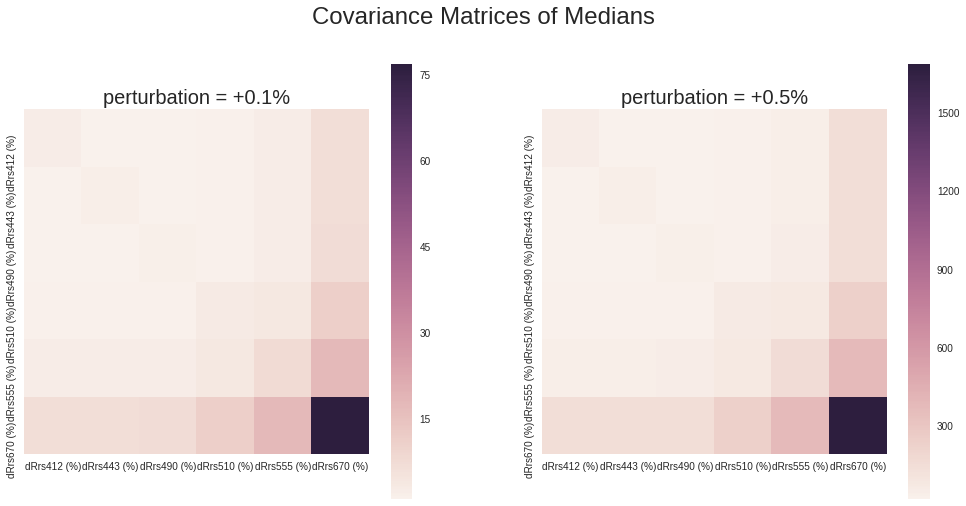

In [48]:
f,ax = pl.subplots(ncols=2,figsize=(17,8))
f.suptitle("Covariance Matrices of Medians", fontsize=24)
sb.set(font_scale=1)
sb.heatmap(dfMed0p1_Cov_rel, square=True, ax=ax[0])
ax[0].set_title("perturbation = +0.1%", fontsize=20)
sb.set(font_scale=1)
sb.heatmap(dfMed0p5_Cov_rel, square=True, ax=ax[1])
ax[1].set_title("perturbation = +0.5%", fontsize=20);

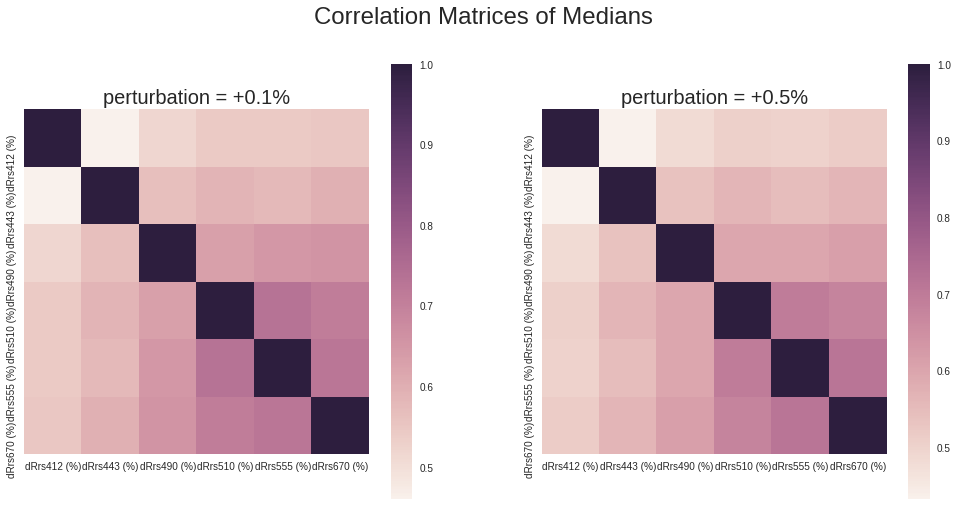

In [50]:
f,ax = pl.subplots(ncols=2,figsize=(17,8))
f.suptitle("Correlation Matrices of Medians", fontsize=24)
sb.set(font_scale=1)
sb.heatmap(dfMed0p1_Corr_rel, square=True, ax=ax[0])
ax[0].set_title("perturbation = +0.1%", fontsize=20)
sb.set(font_scale=1)
sb.heatmap(dfMed0p5_Corr_rel, square=True, ax=ax[1])
ax[1].set_title("perturbation = +0.5%", fontsize=20);

In [51]:
GetUncs(dfMed0p1_Cov_rel)

,Unc
dRrs412 (%),4.5294e+00
dRrs443 (%),4.2164e+00
dRrs490 (%),3.9634e+00
dRrs510 (%),5.6367e+00
dRrs555 (%),8.6336e+00
dRrs670 (%),2.7522e+01


In [53]:
GetUncs(dfMed0p5_Cov_rel)

,Unc
dRrs412 (%),2.2114e+01
dRrs443 (%),2.0183e+01
dRrs490 (%),1.8944e+01
dRrs510 (%),2.6452e+01
dRrs555 (%),3.9903e+01
dRrs670 (%),1.2894e+02


In [158]:
# Re-Loading DataFrames
dfMed0p1 = pd.read_pickle('./pklJar/dfMed0p1.pkl')
dfMed0p5 = pd.read_pickle('./pklJar/dfMed0p5.pkl')
dfMed0p1_Cov = pd.read_pickle('./pklJar/dfMed0p1_Cov.pkl')
dfMed0p5_Cov = pd.read_pickle('./pklJar/dfMed0p5_Cov.pkl')
dfMed0p1_Corr = pd.read_pickle('./pklJar/dfMed0p1_Corr.pkl')
dfMed0p5_Corr = pd.read_pickle('./pklJar/dfMed0p5_Corr.pkl')